In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
basedir = '/content/drive/MyDrive/Dissertation/Datasets'

In [4]:
def load_csv(basedir):
  return pd.read_csv(os.path.join(basedir, 'Cheng et al. (2017).csv'))

In [5]:
df = load_csv('/content/drive/MyDrive/Dissertation/Datasets')

In [6]:
df

year  ...  upper bound 95%
0   1955  ...         9.865000
1   1956  ...         6.039170
2   1957  ...         5.192503
3   1958  ...         5.787500
4   1959  ...         5.407500
..   ...  ...              ...
60  2015  ...        -1.418330
61  2016  ...        -1.138333
62  2017  ...        -0.341667
63  2018  ...        -0.210833
64  2019  ...        -0.970000

[65 rows x 5 columns]

In [7]:
df.shape

(65, 5)

In [8]:
df.head()

year  ...  upper bound 95%
0  1955  ...         9.865000
1  1956  ...         6.039170
2  1957  ...         5.192503
3  1958  ...         5.787500
4  1959  ...         5.407500

[5 rows x 5 columns]

In [9]:
df.tail()

year  ...  upper bound 95%
60  2015  ...        -1.418330
61  2016  ...        -1.138333
62  2017  ...        -0.341667
63  2018  ...        -0.210833
64  2019  ...        -0.970000

[5 rows x 5 columns]

In [10]:
pip install plotnine

In [11]:
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg
%matplotlib inline

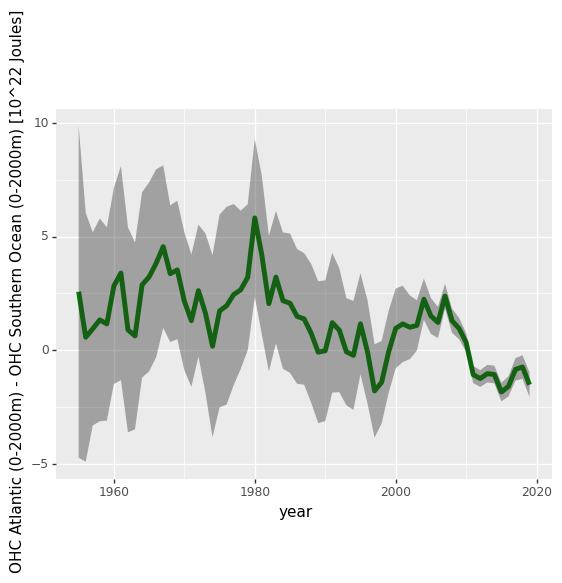

<ggplot: (8768766189185)>

In [13]:
(
    ggplot(df)  
    + aes(x="year", y="OHC Atlantic (0-2000m) - OHC Southern Ocean (0-2000m) [10^22 Joules]")  
    + geom_line(colour = 'green', size = 2) 
    + geom_ribbon(aes(ymax = "lower bound 95%",ymin = "upper bound 95%"),alpha = 0.4)
)

In [14]:
new = df.dropna()

In [15]:
o = len(df.axes[0])
n = len(new.axes[0])
print(f"Deleted Rows= {o-n}")

Deleted Rows= 0


In [16]:
column = []
for col in new.columns:
    column.append(col)

In [17]:
for i in column:
  mean = np.mean(df[i])
  print(f"Mean of {i} = {mean}")

Mean of year = 1987.0
Mean of OHC Atlantic (0-2000m) - OHC Southern Ocean (0-2000m) [10^22 Joules] = 1.2571799123076923
Mean of 2-sigma = 2.610218307692308
Mean of lower bound 95% = -1.3530383953846155
Mean of upper bound 95% = 3.8673982199999988


In [18]:
for i in column:
  median = np.median(df[i])
  print(f"Median of {i} = {median}")

Median of year = 1987.0
Median of OHC Atlantic (0-2000m) - OHC Southern Ocean (0-2000m) [10^22 Joules] = 1.21833
Median of 2-sigma = 2.95917
Median of lower bound 95% = -1.4375
Median of upper bound 95% = 4.20667


In [19]:
from scipy import stats
for i in column:
  mode = stats.mode(df[i])
  print(f"Mode of {i} = {mode[0][0]}")

Mode of year = 1955
Mode of OHC Atlantic (0-2000m) - OHC Southern Ocean (0-2000m) [10^22 Joules] = 1.16167
Mode of 2-sigma = 0.369167
Mode of lower bound 95% = -4.88917
Mode of upper bound 95% = -1.4183299999999999


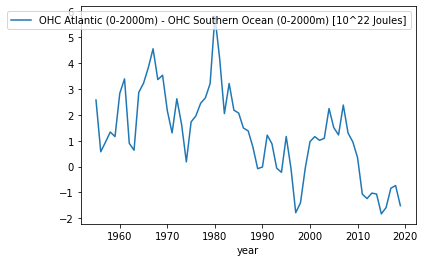

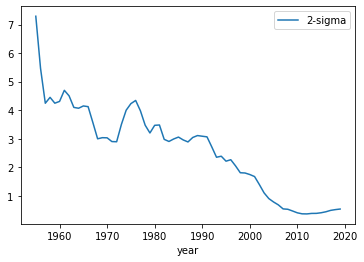

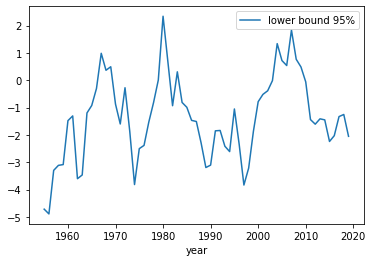

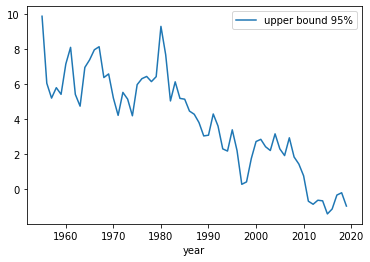

In [20]:
d = 0
for i in column:
  if i != 'year':
    fig = df.plot(x="year", y=[i])
    d = d + 1

In [21]:
!sudo apt-get install jags
!pip install pyjags

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  jags
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,562 kB of archives.
After this operation, 3,522 kB of additional disk space will be used.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ jags 4.3.0-3bionic0 [1,562 kB]
Fetched 1,562 kB in 0s (6,768 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package jags.
(Reading database ... 155222 files and directories curr

In [22]:
import pyjags

In [23]:
pyjags

<module 'pyjags' from '/usr/local/lib/python3.7/dist-packages/pyjags/__init__.py'>

In [24]:
plt.style.use('ggplot')

In [26]:
N = len('year')
alpha = len('OHC Atlantic (0-2000m) - OHC Southern Ocean (0-2000m) [10^22 Joules]')
beta = len('lower bound 95%')
sigma = len('upper bound 95%')

In [27]:
# Generate x uniformly
x = np.random.uniform(0, 100, size=N)
# Generate y as alpha + beta * x + Gaussian error term
y = np.random.normal(alpha + x*beta, sigma, size=N)

In [28]:
# JAGS model code
code = '''
model {
    for (i in 1:N) {
        y[i] ~ dnorm(alpha + beta * x[i], tau)
    }
    alpha ~ dnorm(0.0, 1.0E-4)
    beta ~ dnorm(0.0, 1.0E-4)
    sigma <- 1.0/sqrt(tau)
    tau ~ dgamma(1.0E-3, 1.0E-3)
}
'''

In [29]:
# Load additional JAGS module
pyjags.load_module('glm')

In [30]:
# Initialize model with 4 chains and run 1000 adaptation steps in each chain.
# We treat alpha, beta and sigma as parameters we would like to infer, based
# on observed values of x and y.
model = pyjags.Model(code, data=dict(x=x, y=y, N=N), chains=4, adapt=1000)
 
# 500 warmup / burn-in iterations, not used for inference.
model.sample(500, vars=[])
 
# Run model for 1000 steps, monitoring alpha, beta and sigma variables.
# Returns a dictionary with numpy array for each monitored variable.
# Shapes of returned arrays are (... shape of variable ..., iterations, chains).
# In our example it would be simply (1, 1000, 4).
samples = model.sample(1000, vars=['alpha', 'beta', 'sigma'])

sampling: iterations 2000 of 2000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00


In [31]:
# Use pandas three dimensional Panel to represent the trace:
#x = pd.DataFrame({k: v.squeeze(0) for k, v in samples.items()})
trace = pd.Panel({k: v.squeeze(0) for k, v in samples.items()})
#trace.axes[0].name = 'Variable'
##trace.axes[1].name = 'Iteration'
#trace.axes[2].name = 'Chain'
return trace

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  This is separate from the ipykernel package so we can avoid doing imports until


TypeError: ignored

In [32]:
x = {k: v.squeeze(0) for k, v in samples.items()}

In [33]:
x

{'alpha': array([[124.90691693, 164.44219021,  20.44633753,  88.42441405],
        [126.62809781, 157.95612082,   0.24086659, 122.42746626],
        [147.72801893, 155.47501842,  11.76491177, 124.94707203],
        ...,
        [ 11.56729066, -32.026756  ,  54.64630871,  46.66263397],
        [ 18.03859217, -16.01028198,  46.81041173,  41.97159566],
        [ 31.13596228, -67.90299368,  53.69463965,  46.71530859]]),
 'beta': array([[14.15888535, 13.67099516, 15.74796018, 13.67767983],
        [13.59242873, 13.61059364, 15.99694234, 14.08501679],
        [14.00134036, 13.59550829, 15.68427457, 13.98253015],
        ...,
        [15.83520892, 16.34694347, 15.24052877, 15.25910783],
        [15.49839212, 16.65207381, 15.19024289, 15.37118694],
        [15.57148932, 16.76089143, 15.31968591, 15.43800317]]),
 'sigma': array([[29.65670775, 24.1684872 , 11.69854787, 81.87534233],
        [61.66192611, 22.25351365, 13.96552076, 15.51052826],
        [27.14944411, 14.2689061 , 16.26433073, 27.2

In [ ]:
# Point estimates:
print(trace.to_frame().mean())
 
# Possible output:
# Variable
# alpha 71.693096
# beta 19.860774
# sigma 49.790683

In [ ]:
# Bayesian equal-tailed 95% credible intervals:
print(trace.to_frame().quantile([0.05, 0.95]))
 
# Possible output:
# Variable alpha beta sigma
# 0.05 61.98259 19.694937 46.472748
# 0.95 81.27412 20.025410 53.284573

In [ ]:
def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, fontsize='xx-large')
 
    # Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
     # Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    # Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
    # Save figure
    plt.tight_layout()
    fig.savefig('{}.png'.format(var))
 
# Display diagnostic plots
for var in trace:
    plot(trace, var)
 
# Scatter matrix plot:
scatter_matrix(trace.to_frame(), diagonal='density')
plt.savefig('scatter_matrix.png')